In [1]:
"""
Visual Sudoku problem in CPMpy


Requires to install 'torchvision' and 'tqdm' python3 packages

If you get an AttributeError: 'FloatProgress' object has no attribute 'style'
then fix the tqdm release to 4.40.0 as such:
    pip3 install tqdm==4.40.0
"""

from cpmpy import * 
import os
import numpy as np 
import torch
import tqdm # version 4.40.0
from torchvision import datasets, transforms

from cpmpy.solvers.ortools import CPM_ortools

import matplotlib.pyplot as plt


# Solve standard "Numerical" Sudoku

Let's start off by solving a standard Sudoku puzzle. We build a CPMpy model of Sudoku and solve the puzzle using Constraint Programming.

In [2]:
e = 0 # empty cell
numerical_sudoku = np.array([
    [e, e, e,  2, e, 5,  e, e, e],
    [e, 9, e,  e, e, e,  7, 3, e],
    [e, e, 2,  e, e, 9,  e, 6, e],

    [2, e, e,  e, e, e,  4, e, 9],
    [e, e, e,  e, 7, e,  e, e, e],
    [6, e, 9,  e, e, e,  e, e, 1],

    [e, 8, e,  4, e, e,  1, e, e],
    [e, 6, 3,  e, e, e,  e, 8, e],
    [e, e, e,  6, e, 8,  e, e, e]
])

In [3]:
# Sudoku modeling  

def model_sudoku(grid):
    '''
        Build a model for standard Sudoku by creating 81 Intvars (one per cell) and 
        posting standard Sudoku constraints on row, columns and 3x3 blocks.
    '''
    n = len(grid)
    b = np.sqrt(n).astype(int)

    # decision vars
    puzvar = IntVar(1,n, shape=grid.shape, name='cell')

    # alldiff constraints
    constraints = []
    constraints += [alldifferent(row) for row in puzvar]
    constraints += [alldifferent(col) for col in puzvar.T]

    for i in range(0,n,b):
        for j in range(0,n,b):
            constraints += [alldifferent(puzvar[i: i +b, j:j+b])]

    model = Model(constraints)
    # we need access to decision vars later on
    return puzvar, model


def pretty_print_sudoku(grid, add_marker=None):
    """
        Helper function to print a numerical sudoku puzzle  
    """
    n = grid.shape[0]
    b = np.sqrt(n)
    out = ""
    for r in range(0,n):
        for c in range(0,n):
            out += str(grid[r,c])
            out += '* ' if add_marker is not None and add_marker[r,c] else '  '
            if (c+1) % b == 0 and c != n-1: # end of block
                out += '| '
        out += '\n'
        if (r+1) % b == 0 and r != n-1: # end of block
            out += ('-'*n)+'+-'+('-'*n)+'+'+('-'*n)+'\n'
    print(out)

In [4]:
# Let's solve the puzzle above
puzvar, model = model_sudoku(numerical_sudoku)
# fix variables for which the value is given
is_given = numerical_sudoku > 0 
model += [puzvar[is_given] == numerical_sudoku[is_given]]
model.solve() 
solution_numerical = puzvar.value() 
pretty_print_sudoku(solution_numerical)

3  7  8  | 2  6  5  | 9  1  4  
5  9  6  | 8  1  4  | 7  3  2  
1  4  2  | 7  3  9  | 5  6  8  
---------+----------+---------
2  1  7  | 3  8  6  | 4  5  9  
8  5  4  | 9  7  1  | 6  2  3  
6  3  9  | 5  4  2  | 8  7  1  
---------+----------+---------
7  8  5  | 4  2  3  | 1  9  6  
4  6  3  | 1  9  7  | 2  8  5  
9  2  1  | 6  5  8  | 3  4  7  



# Solve MNIST "Visual" Sudoku 

In this variant of the Sudoku puzzle, digits are replaced by binary images sampled from [MNIST](http://yann.lecun.com/exdb/mnist/).

Solving a visual Sudoku requires an hybrid approach, combining Machine Learning and Constraint Solving (see [Hybrid Classification and Reasoning for Image-based Constraint Solving](https://doi.org/10.1007/978-3-030-58942-4_24)). 

In [5]:
# Let's build Visual Sudoku problem from MNIST data
# Normalize data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the MNIST data
testset = datasets.MNIST('.', download=True, train=False, transform=transform)
# map digit -> corresponding images sample
digit_indices = {k:torch.LongTensor(*np.where(testset.targets == k)) for k in range(1,10)}
print("Data loaded.")


N_CHANNEL = 1 # MNIST images are in grey scale 
IMAGE_WIDTH = 28 # MNIST image width
IMAGE_HEIGHT = 28 # MNIST image height


def sample_visual_sudoku(sudoku_puzzle):
    """
        Turn the given `sudoku_puzzle` into a visual puzzle by replace numeric values
        by images from MNIST. 
    """
    # fix the seed
    rng = np.random.RandomState(243)

    # Visual Sudoku Tensor of shape puzzle_width x puzzle_height x n_channel x image_width x image_height
    sudoku_torch_dimension = sudoku_puzzle.shape + (N_CHANNEL, IMAGE_WIDTH, IMAGE_HEIGHT,)
    vizsudoku = torch.zeros(sudoku_torch_dimension, dtype=torch.float32)

    # sample dataset indices for each non-zero digit
    for val in np.unique(sudoku_puzzle[sudoku_puzzle > 0]):
        val_idx = np.where(sudoku_puzzle == val)
        # randomly sample different MNIST images for a given digit all at once
        idx = torch.LongTensor(rng.choice(digit_indices[val], len(sudoku_puzzle[val_idx])))
        vizsudoku[val_idx] = torch.stack([testset[i][0] for i in idx])
    return vizsudoku

# Let's also define a helper function to visualize the visual puzzle
from mpl_toolkits.axes_grid1 import ImageGrid
def show_grid_img(visual_sudoku, in_green=None, in_red=None, title=None):
    images =visual_sudoku.reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH)
    images = (255 * images).int()
    dim = visual_sudoku.shape[0]
    fig = plt.figure(figsize=(8,8))
    grid = ImageGrid(fig, 111, nrows_ncols=(dim,dim), axes_pad=0.03)
    
    if title:
        fig.suptitle(title, fontsize=16)

    # cells to plot in green | red
    N = len(images)
    if in_green is None:
        in_green = np.zeros(N, dtype=bool)
    if in_red is None:
        in_red = np.zeros(N, dtype=bool)
    in_green = in_green.flatten()
    in_red = in_red.flatten()
    
    for ax, index in zip(grid, range(len(images))):
        ax.axis('off')
        color = 'gray'
        if in_red[index]:
            color = 'autumn'
        if in_green[index]:
            color = 'summer'
        ax.imshow(images[index].numpy().squeeze(), cmap=color)
        #ax.title(title)

Data loaded.


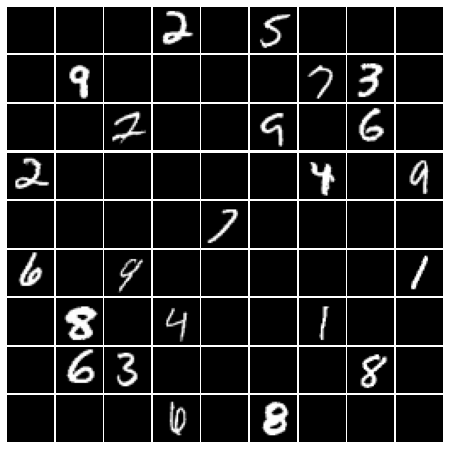

In [6]:
# Let's visualize a visual sudoku!
visual_sudoku = sample_visual_sudoku(numerical_sudoku)
show_grid_img(visual_sudoku)


## Neural Network Classifier 

Convolutional Neural Networks (CNN) are the best for the digit classification task. We use the [LeNet](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) architecture, which uses two convolutional layers followed by two fully-connected layers. 

![](https://pytorch.org/tutorials/_images/mnist.png)

For convenience, this CNN was already pre-trained on MNIST training data

In [7]:
## Convolutional Neural Network for digit classification

from torch import nn 
import torch.nn.functional as F
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, 1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*5*16) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

def load_classifier(clf_classname, path):
    """
        Initialize a new CNN classifier by
        loading pre-trained weights stored in `path` file
    """
    net = clf_classname()
    state_dict = torch.load(path, map_location=lambda storage, loc: storage)
    net.load_state_dict(state_dict)
    return net

@torch.no_grad()
def predict_proba_sudoku(neuralnet, vizsudoku):
    """
        Assign a probabilistic vector to each image of the visual puzzle
    """
    grid_shape = vizsudoku.shape[:2]
    # reshape from 9x9x1x28x28 to 81x1x28x28 
    pred = neuralnet(vizsudoku.flatten(0,1))
    # our NN return 81 probabilistic vector: an 81x10 matrix
    return pred.reshape(*grid_shape,10).detach().numpy() # reshape as 9x9x10 tensor for easier visualisation

# load pre-trained classifier
nn_filehandle = 'weights/visual_sudoku_lenet_mnist_weights.pt'
if not os.path.exists(nn_filehandle):
    os.makedirs('weights')
    url = "https://github.com/CPMpy/cpmpy/raw/vizsudoku_example/examples/advanced/weights/visual_sudoku_lenet_mnist_weights.pt"
    torch.hub.download_url_to_file(url, nn_filehandle)
cnn = load_classifier(LeNet, nn_filehandle) 

print("Pre-trained LeNet loaded and ready.")


Pre-trained LeNet loaded and ready.


Let's define helper function to visualize an input image and its output probability distribution

Predicted Digit = 6 	Actual = 6
Predicted Digit = 7 	Actual = 7


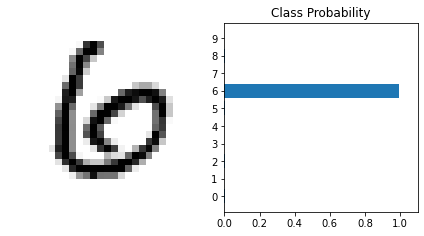

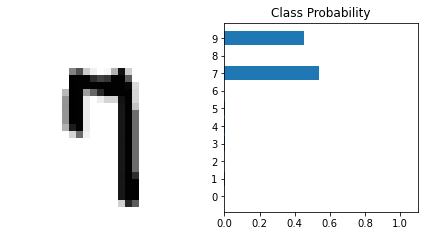

In [8]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.numpy().squeeze(), cmap='gray_r');
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

@torch.no_grad() # turn off gradients calculation
def show_one_prediction(model, data, i=0):
    img, label = data[i]
    logps = model(img.unsqueeze(0))
    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    view_classify(img, ps)
    print("Predicted Digit =", probab.index(max(probab)), "\tActual =",label)

# visualize how well our current CNN can accurately classify images
show_one_prediction(cnn, testset, 11)
show_one_prediction(cnn, testset, 80)

The figures above show that our pretrained CNN classifier is rather weak. It classifies both images correctly. However, in the second case the network is hesitates between 7 and 9. Potential misclassifcations as well as classifier confidence have consequences when we use this CNN to solve a Visual Sudoku.  

In [9]:
## Helper Functions


# helper function to project the numerical solution onto the visual space
def project_numeric_to_visual(numerical_solution, numerical_puzzle, visual_puzzle, is_given):
    """
        Build a visual version of the `numerical_solution`, by filling in cells in
        the `visual_puzzle´ with MNIST images
    """
    images = (255 * visual_puzzle).int().numpy()

    # project same images as in the visual puzzle, on cell whose value did not change
    visual_solution = torch.zeros_like(visual_puzzle)# np.zeros_like(images)
    #same_digits = numerical_solution == numerical_puzzle
    visual_solution[is_given,:,:,:] = visual_puzzle[is_given,:,:,:]

    visual_solution = visual_solution.reshape(-1, N_CHANNEL, IMAGE_WIDTH, IMAGE_HEIGHT)
    #same_digits = same_digits.flatten()
    # sample the rest from MNIST 
    for i, given in np.ndenumerate(is_given.flatten()):
        if not given:
            # sample from MNIST
            val = numerical_solution.flatten()[i]
            img,_ = testset[digit_indices[val][0]]
            visual_solution[i,:,:,:] = img
    return visual_solution.reshape(numerical_solution.shape + (N_CHANNEL, IMAGE_WIDTH, IMAGE_HEIGHT))

In [10]:
# boolean matrix which tells if a cell contains an image or not
is_given = numerical_sudoku > 0

print('Which cells are clues?\r')
pretty_print_sudoku(is_given.astype(int))

Which cells are clues?
0  0  0  | 1  0  1  | 0  0  0  
0  1  0  | 0  0  0  | 1  1  0  
0  0  1  | 0  0  1  | 0  1  0  
---------+----------+---------
1  0  0  | 0  0  0  | 1  0  1  
0  0  0  | 0  1  0  | 0  0  0  
1  0  1  | 0  0  0  | 0  0  1  
---------+----------+---------
0  1  0  | 1  0  0  | 1  0  0  
0  1  1  | 0  0  0  | 0  1  0  
0  0  0  | 1  0  1  | 0  0  0  



Let's see how our CNN performs when we only consider the predicted values across the given cells. 

probability tensor of shape  (9, 9, 10)
Maximum-likelihood predictions from the CNN
0  0  0  | 2  0  5  | 0  0  0  
0  9  0  | 0  0  0  | 7  3  0  
0  0  2  | 0  0  9  | 0  6  0  
---------+----------+---------
2  0  0  | 0  0  0  | 4  0  4* 
0  0  0  | 0  2* 0  | 0  0  0  
6  0  9  | 0  0  0  | 0  0  1  
---------+----------+---------
0  8  0  | 4  0  0  | 1  0  0  
0  6  3  | 0  0  0  | 0  8  0  
0  0  0  | 8* 0  8  | 0  0  0  



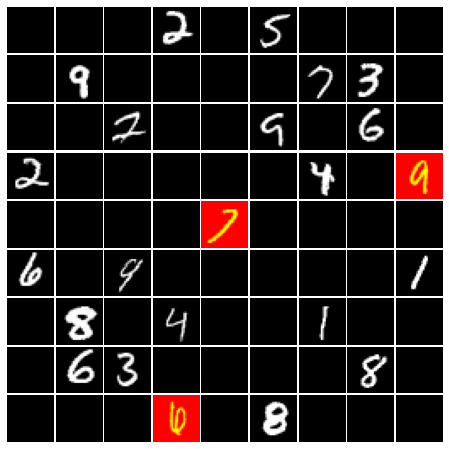

In [11]:
# convolutional neural network predictions 
predictions = predict_proba_sudoku(cnn, visual_sudoku)
print("probability tensor of shape ", predictions.shape)

# we do not want to predict a zero as it is not in the domain of Sudoku decision variables
predictions[:,:,0] = -10000
most_likely_label = np.zeros_like(numerical_sudoku)
most_likely_label[is_given] =  np.argmax(predictions, axis=-1)[is_given]

# boolean matrix to mark each wrong classification
wrong_label = most_likely_label != numerical_sudoku 

print('Maximum-likelihood predictions from the CNN')
pretty_print_sudoku(most_likely_label, wrong_label)
show_grid_img(visual_sudoku, in_red=wrong_label)

In the current visual puzzle, three images are wrongly classified by the neural network (shown in red in the figure above). This prevents the solver from finding a solution for this input. 

## Visual Sudoku Solver in CPMpy 

Now we build a model in CPMpy to solve the Visual Sudoku Problem. Throughout this notebook, aside from the visual puzzle, we assume that we also know which cells contains an image (givens) and which cells are blank (value has to be found by the solver). 



## Naive Approach

The intuitive way to solve this problem is to proceed in a purely sequential way:

1. For each given, take the most likely label as a deterministic input
2. Then solve the resulting Sudoku puzzle with CP. 


In [12]:
def solve_vizsudoku_naive(puzvar, model, logprobs, is_given):
    """
        Baseline: take most likely digit as deterministic input
    """
    # MNIST contains 0 but Sudoku dvars domains is 1..9
    logprobs[:,:,0] = -10000
    most_likely = np.argmax(logprobs, axis=-1)
    model += [puzvar[is_given] == most_likely[is_given]]
    if model.solve() is not False:
        return puzvar.value()
    else:
        # unsatisfiable, we return the input used, with 0's for unkonwns
        inp = np.zeros_like(puzvar)
        inp[is_given] = most_likely[is_given]
        return inp

In [13]:
# Errors from the CNN lead to an infeasile sudoku. 
# We expect our naive approach to fail to find any solution
puzvar, model = model_sudoku(is_given)
solution_naive = solve_vizsudoku_naive(puzvar, model, predictions, is_given)
pretty_print_sudoku(solution_naive, (np.array(solution_naive) != numerical_sudoku))
print('Satifiable?', not np.any(solution_naive==0))

0  0  0  | 2  0  5  | 0  0  0  
0  9  0  | 0  0  0  | 7  3  0  
0  0  2  | 0  0  9  | 0  6  0  
---------+----------+---------
2  0  0  | 0  0  0  | 4  0  4* 
0  0  0  | 0  2* 0  | 0  0  0  
6  0  9  | 0  0  0  | 0  0  1  
---------+----------+---------
0  8  0  | 4  0  0  | 1  0  0  
0  6  3  | 0  0  0  | 0  8  0  
0  0  0  | 8* 0  8  | 0  0  0  

Satifiable? False


## Maximum Likelihood Approach

The solver can correct misclassifications because they disregard Sudoku constraints.
Hence, the solver should reason over probabilities given by the CNN. 
To that end, we need to turn the satisfaction problem of sudoku into an optimisation problem, where we optimize for maximum log likelihood [[1]](#1). 

This means adding the following objective function: a weighted sum of the decision variables. Each weight is the log-probability of that decision variable being equal to the corresponding predicted value. 

### References 
<a id="1">[1]</a>
Mulamba, M., Mandi, J., Canoy, R., and Guns, T. (2020, September). Hybrid classification and reasoning for image-based constraint solving. In International Conference on Integration of Constraint Programming, Artificial Intelligence, and Operations Research (pp. 364-380). Springer, Cham.

In [14]:
# constant to turn float into int
PRECISION = 1e-4

def solve_vizsudoku_max_likelihood(model, puzvar, logprobs, is_given):
    '''
        Hyrbid 1 approach, as described in https://arxiv.org/pdf/2003.11001.pdf

        We add an objective function, turning the satisfaction problem into an optimisation problem.
        The goal is to find the feasible solution which maximizes the joint log-likelihood accross all givens. 

        The objective function is a weighted sum of the decision variables for givens,
         with as weight the log-probability of that decision variable being equal to the corresponding predicted value
    '''
    # divide by PRECISION to turn logprobs into integers. 
    lprobs = cparray(-logprobs/PRECISION).astype(int)

    # objective function: max log likelihood prediction for givens
    # (probability vector indexed by an integer decision variable) 
    obj = sum(lp[v] for lp,v in zip(lprobs[is_given], puzvar[is_given]))

    # Because we have log-probabilities, we flip the sign to only have positives 
    # Hence the optimisation becomes a minimisation problem
    model.minimize(obj)

    if model.solve() is not False:
        return puzvar.value()
    else:
        return np.zeros_like(puzvar)

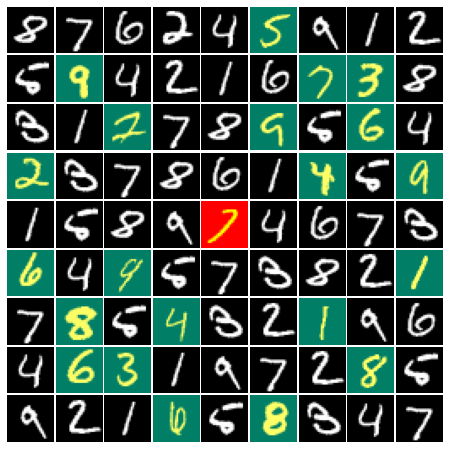

In [15]:
# Let's solve the visual sudoku with the hybrid approach
puzvar2, model2 = model_sudoku(is_given)
solution_max_likelihood = solve_vizsudoku_max_likelihood(model2, puzvar2, predictions, is_given)
visual_max_likely = project_numeric_to_visual(solution_max_likelihood, numerical_sudoku, visual_sudoku, is_given)

# print the output of the hybrid approach
#pretty_print_sudoku(solution_max_likelihood, wrong_label)
corrected_label = solution_max_likelihood == numerical_sudoku 
show_grid_img(visual_max_likely, in_red=wrong_label, in_green=corrected_label)

An image is green if the CP solver labelled it correctly.

This maximum likelihood formulation looks better, as it actually finds a feasible solution, whereas using the naive approach did not get us anywhere. 2 out of 3 misclassifications are corrected by the solver.

## Higher-order knowledge exploitation

As we now model it as an optimisation problem, a visual sudoku instance may have many feasible solutions as shown above.

However, any valid sudoku puzzle only admits a unique solution for a set of givens. To improve the efficiency of our hybrid approach, we can actually exploit this **uniqueness property** :

* When solver finds optimal solution, add the resulting assignment as a no-good and try to solve again
* if any feasible solution is found this way, previous assignment for given cells does not lead to unique solution

Iterate over these steps until the uniqueness property is satisfied. In practice, we may need to loop several times depending on the accuracy of the classifier.

In [16]:
def is_unique(solution, is_given):
    '''
        Check that `solution` is unique, when we solve starting from clues located 
        as specified by `is_given`
    '''
    # get new Sudoku model and decision vars
    puzvar, model = model_sudoku(is_given)
    # constraint on values (cells that are non-empty)
    model += [puzvar[is_given] == solution[is_given]]
    # forbid current solution 
    model += ~all((puzvar == solution).flatten()) #FIXME auto-flatten 2d dvar arrays?
    model= CPM_ortools(model)
    # There should not exist another feasible solution starting from these clues
    return model.solve(stop_after_first_solution=True) == False

def solve_vizsudoku_higher_oder(model, puzvar, logprobs, is_given, max_iter=10):
    """
        Hyrbid 2 approach, built on top of Hybrid 1, as described in https://arxiv.org/pdf/2003.11001.pdf

        Iteratively solve the Visual Sudoku puzzle, adding nogoods until givens value in the current assignment 
        lead to a unique solution.

        `max_iter` controls the amount of attempd

    """
    i = 0
    while not is_unique(puzvar.value(), is_given):
        if i == max_iter:
            break 
        # block current solution
        model += ~all((puzvar[is_given] == puzvar[is_given].value()))
        solve_vizsudoku_max_likelihood(model, puzvar, logprobs, is_given)
        i += 1
    return puzvar.value()

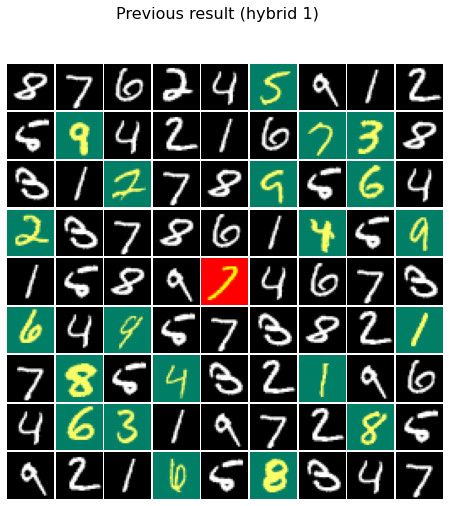

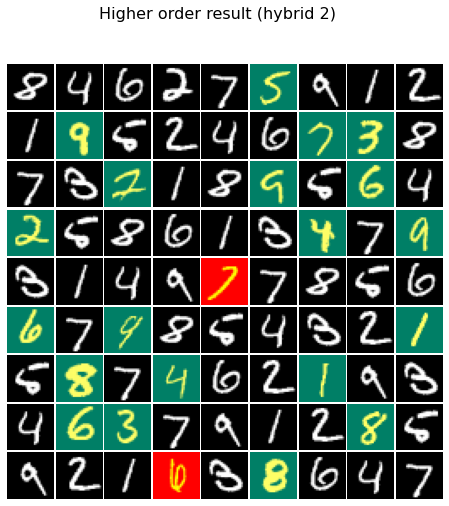

In [17]:
# previous result:
show_grid_img(visual_max_likely, in_red=wrong_label, in_green=corrected_label, title="Previous result (hybrid 1)")

# Let's do and visualise new result (hybrid2):
solution_higher_order = solve_vizsudoku_higher_oder(model2, puzvar2, predictions, is_given)
visual_higher_order = project_numeric_to_visual(solution_higher_order, numerical_sudoku, visual_sudoku, is_given)

# print the output of the hybrid approach
#pretty_print_sudoku(solution_higher_order, wrong_label)
corrected_higher_order = solution_higher_order == numerical_sudoku 
show_grid_img(visual_higher_order, in_red=wrong_label, in_green=corrected_higher_order, title="Higher order result (hybrid 2)")